# Installing libraries

In [ ]:
%%writefile requirements.txt

recbole>=1.1.1
torch_geometric
torch>=1.7.0
pandas
matplotlib
seaborn
scikit-learn
tensorflow
keras
scikit-surprise
ijson
implicit
annoy
pyarrow

Overwriting requirements.txt


In [3]:
!pip install -r requirements.txt


  Obtaining dependency information for recbole>=1.1.1 from https://files.pythonhosted.org/packages/ab/fe/7d606cb7cd2b166a36b100cb9435d21014ceee16c192d972deb0976967a8/recbole-1.2.1-py3-none-any.whl.metadata
  Using cached recbole-1.2.1-py3-none-any.whl.metadata (1.4 kB)
  Obtaining dependency information for torch_geometric from https://files.pythonhosted.org/packages/03/9f/157e913626c1acfb3b19ce000b1a6e4e4fb177c0bc0ea0c67ca5bd714b5a/torch_geometric-2.6.1-py3-none-any.whl.metadata
  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
  Obtaining dependency information for torch>=1.7.0 from https://files.pythonhosted.org/packages/84/57/2f64161769610cf6b1c5ed782bd8a780e18a3c9d48931319f2887fa9d0b1/torch-2.8.0-cp311-cp311-win_amd64.whl.metadata
  Using cached torch-2.8.0-cp311-cp311-win_amd64.whl.metadata (30 kB)
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/fc/8e/0a18d6d7d2d0a2e66585032a760d13662e5250c784d53ad50434e9560991/m


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!python --version


Python 3.11.5


# Preprocessing


### Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train= pd.read_csv('train.csv')


In [ ]:
test= pd.read_csv('test.csv')

### Get Deezer data

In [3]:
from collections import deque
import time

class RateLimiter:
    def __init__(self, max_calls=50, period=5):
        self.max_calls = max_calls
        self.period = period
        self.calls = deque()

    async def acquire(self):
        now = time.monotonic()
        while len(self.calls) >= self.max_calls and now - self.calls[0] < self.period:
            sleep_time = self.period - (now - self.calls[0])
            await asyncio.sleep(sleep_time)
            now = time.monotonic()
        self.calls.append(now)
        while self.calls and now - self.calls[0] >= self.period:
            self.calls.popleft()


In [ ]:
import pandas as pd
import os
import aiohttp
import asyncio
from tqdm.asyncio import tqdm_asyncio
import nest_asyncio
import random

# Allow asyncio in notebooks
nest_asyncio.apply()

# Global retries
max_retries = 2
async def fetch_track(session, track_id, max_retries):
    url = f"https://api.deezer.com/track/{track_id}"
    for attempt in range(max_retries):
        try:
            async with session.get(url, timeout=10) as resp:
                data = await resp.json()
                if resp.status == 200 and "error" not in data:
                    album = data.get("album", {})
                    artist = data.get("artist", {})
                    return {
                        "media_id": int(track_id),
                        "track_name": data.get("title"),
                        "artist_name": artist.get("name"),
                        "album_name": album.get("title"),
                        "release_date": album.get("release_date"),
                        "bpm": data.get("bpm"),
                        "gain": data.get("gain"),
                        "genre_id": album.get("genre_id"),
                        "genre_name": None
                    }
                elif "error" in data and data["error"].get("message") == "Quota limit exceeded":
                    # Pause and retry after API reset
                    print(f"[WARN] Track {track_id} quota exceeded. Waiting 5s...")
                    await asyncio.sleep(5)
                else:
                    raise ValueError(f"HTTP {resp.status} or unknown error")
        except Exception as e:
            if attempt < max_retries:
                wait = (2 ** attempt) + random.random()
                print(f"[WARN] Track {track_id}, attempt {attempt+1}: {e}. Retrying in {wait:.2f}s")
                await asyncio.sleep(wait)
            else:
                print(f"[ERROR] Track {track_id} failed after {max_retries} retries")
                return None



async def fetch_deezer_metadata_async(track_ids, output_file="deezer_metadata.csv",
                                      concurrency=5, batch_size=50,max_retries=max_retries):
    # Load previous checkpoint
    if os.path.exists(output_file):
        existing_df = pd.read_csv(output_file)
        existing_df['media_id'] = existing_df['media_id'].astype('int32')
    else:
        existing_df = pd.DataFrame(columns=[
            "media_id","track_name","artist_name","album_name",
            "release_date","bpm","gain","genre_id","genre_name"
        ])

    fetched_metadata = existing_df.to_dict('records')

    bad_ids = existing_df[
        existing_df["artist_name"].isna() | existing_df["track_name"].isna()
    ]["media_id"].tolist()

    already_good_ids = set(
        existing_df.dropna(subset=["artist_name","track_name"])["media_id"]
    )
    ids_to_fetch = [tid for tid in track_ids if tid not in already_good_ids] + bad_ids
    ids_to_fetch = list(set(ids_to_fetch))  # deduplicate
    print(f"{len(ids_to_fetch)} tracks need Deezer API calls")

    limiter = RateLimiter(max_calls=50, period=5)
    connector = aiohttp.TCPConnector(limit=concurrency)

    async with aiohttp.ClientSession(connector=connector) as session:
        for i in range(0, len(ids_to_fetch), batch_size):
            batch = ids_to_fetch[i:i+batch_size]
            tasks = []
            for tid in batch:
                await limiter.acquire()
                tasks.append(fetch_track(session, tid,max_retries=max_retries))

            for result in tqdm_asyncio.as_completed(tasks, total=len(tasks)):
                track_data = await result
                if track_data:
                    fetched_metadata.append(track_data)

            pd.DataFrame(fetched_metadata).to_csv(output_file, index=False)

            print(f"Sleeping 5 seconds before next batch...")
            await asyncio.sleep(5)

    return pd.DataFrame(fetched_metadata)




def fetch_deezer_metadata(track_ids, output_file="deezer_metadata.csv",
                          batch_size=50, concurrency=10):
    loop = asyncio.get_event_loop()
    return loop.run_until_complete(
        fetch_deezer_metadata_async(track_ids,
                                    output_file=output_file,
                                    batch_size=batch_size,
                                    concurrency=concurrency)
    )




In [34]:
import pandas as pd
import zipfile
import ijson
import os
import numpy as np

def load_wasabi_with_deezer_ids(zip_path, valid_ids, already_have_ids=set(),
                                checkpoint_file="wasabi_checkpoint.csv", save_every=5000):
    """
    Stream through Wasabi songs.json and extract Deezer metadata for valid IDs.
    Uses checkpointing to save progress incrementally.
    All IDs stored as int32 to save memory.
    Logs skipped/invalid Deezer IDs.
    """
    collected = []

    # Ensure all IDs are int32 for matching
    valid_ids = set(np.int32(x) for x in valid_ids)
    already_have_ids = set(np.int32(x) for x in already_have_ids)

    # Load checkpoint if exists
    if os.path.exists(checkpoint_file):
        checkpoint_df = pd.read_csv(checkpoint_file)
        parsed_ids = set(checkpoint_df["media_id"].astype('int32'))
        print(f"Resuming Wasabi checkpoint with {len(parsed_ids)} tracks already parsed")
    else:
        checkpoint_df = pd.DataFrame(columns=["media_id","track_name","artist_name","genre"])
        parsed_ids = set()

    skipped = 0
    errors = 0

    with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open("song.json") as f:
            parser = ijson.items(f, "item")
            counter = 0
            for song in parser:
                deezer_id_str = song.get("id_song_deezer")

                if not deezer_id_str:  # skip None or empty string
                    skipped += 1
                    continue

                try:
                    deezer_id = np.int32(int(deezer_id_str))
                except ValueError:
                    errors += 1
                    print(f"Could not parse id_song_deezer='{deezer_id_str}' for track '{song.get('title')}'")
                    continue

                if deezer_id in valid_ids and deezer_id not in parsed_ids and deezer_id not in already_have_ids:
                    collected.append({
                        "media_id": deezer_id,
                        "track_name": song.get("title"),
                        "artist_name": song.get("name"),
                        "genre": song.get("album_genre")
                    })
                    counter += 1

                    # Save progress periodically
                    if counter % save_every == 0:
                        tmp_df = pd.DataFrame(collected)
                        checkpoint_df = pd.concat([checkpoint_df, tmp_df], ignore_index=True)
                        checkpoint_df.to_csv(checkpoint_file, index=False)
                        collected = []
                        print(f" Checkpoint saved with {len(checkpoint_df)} total matches")

    # Save final progress
    if collected:
        tmp_df = pd.DataFrame(collected)
        checkpoint_df = pd.concat([checkpoint_df, tmp_df], ignore_index=True)
        checkpoint_df.to_csv(checkpoint_file, index=False)
        print(f" Final checkpoint saved with {len(checkpoint_df)} total matches")

    print(f"Summary: {len(checkpoint_df)} matches, {skipped} skipped (empty), {errors} errors (bad IDs)")
    return checkpoint_df


In [4]:

def build_train_test_with_metadata(train_df, test_df,
                                   mood_mapping_df=None,
                                   wasabi_checkpoint_path="wasabi_checkpoint.csv",
                                   output_file="deezer_metadata.csv",
                                   batch_size=500,
                                   concurrency=100):
    # 1. Collect all unique IDs
    all_track_ids = pd.concat([train_df['media_id'], test_df['media_id']]).astype('int32').unique()
    valid_ids = set(all_track_ids)

    # 2. Load existing Deezer metadata
    if os.path.exists(output_file):
        existing_metadata_df = pd.read_csv(output_file)
        existing_metadata_df['media_id'] = existing_metadata_df['media_id'].astype('int32')
        existing_ids = set(existing_metadata_df['media_id'])
    else:
        existing_metadata_df = pd.DataFrame(columns=['media_id','track_name','artist_name','album_name','release_date'])
        existing_ids = set()

    # 3. Load Mood dataset (skip IDs already present)
    if mood_mapping_df is not None:
        mood_metadata = (
            mood_mapping_df[['dzr_sng_id','track_name','artist_name']]
            .drop_duplicates()
            .rename(columns={'dzr_sng_id':'media_id'})
        )
        mood_metadata['media_id'] = mood_metadata['media_id'].astype('int32')
        mood_metadata = mood_metadata[~mood_metadata['media_id'].isin(existing_ids)]
        mood_ids = set(mood_metadata['media_id'])
    else:
        mood_metadata = pd.DataFrame(columns=['media_id','track_name','artist_name'])
        mood_ids = set()

    # 4. Load Wasabi checkpoint CSV
    if os.path.exists(wasabi_checkpoint_path):
        wasabi_df = pd.read_csv(wasabi_checkpoint_path)
        wasabi_df['media_id'] = wasabi_df['media_id'].astype('int32')
        wasabi_ids = set(wasabi_df['media_id'])
    else:
        wasabi_df = pd.DataFrame(columns=['media_id','track_name','artist_name','genre'])
        wasabi_ids = set()

    print(f"{len(mood_ids)} tracks filled from Mood dataset")
    print(f"{len(wasabi_ids)} tracks filled from Wasabi dataset")

    # 5. Combine existing + Mood + Wasabi metadata
    deezer_metadata_df = pd.concat([existing_metadata_df, mood_metadata, wasabi_df], ignore_index=True)

    # 6. Determine IDs still needing Deezer API calls
    existing_set = set(deezer_metadata_df['media_id'].unique())
    ids_to_fetch = [tid for tid in all_track_ids if tid not in existing_set]
    print(f"{len(ids_to_fetch)} tracks need Deezer API calls")

    # 7. Fetch missing metadata (async in notebook)
    if ids_to_fetch:
        fetched_metadata_df = fetch_deezer_metadata(
        ids_to_fetch,
        output_file=output_file,
        concurrency=concurrency
    )
    fetched_metadata_df['media_id'] = fetched_metadata_df['media_id'].astype('int32')
    deezer_metadata_df = pd.concat([deezer_metadata_df, fetched_metadata_df], ignore_index=True)


    # 8. Merge metadata back into train/test
    deezer_train_df = train_df.merge(deezer_metadata_df, on='media_id', how='left')
    deezer_test_df = test_df.merge(deezer_metadata_df, on='media_id', how='left')

    return deezer_train_df, deezer_test_df


In [35]:
# Load Mood Detection mapping (train+valid+test)
mood_train = pd.read_csv("trainmood.csv")
mood_valid = pd.read_csv("validationmood.csv")
mood_mapping_df = pd.concat([mood_train, mood_valid], ignore_index=True)



### Deezer API Metadata enrichment

In [ ]:
deezer_train_df, deezer_test_df = build_train_test_with_metadata(
    train_df=train,
    test_df=test,
    output_file="deezer_metadata.csv"
)


0 tracks filled from Mood dataset
51793 tracks filled from Wasabi dataset
525 tracks need Deezer API calls
525 tracks need Deezer API calls


  0%|          | 0/50 [00:00<?, ?it/s]

[WARN] Track 134881376, attempt 1: HTTP 200 or unknown error. Retrying in 1.43s
[WARN] Track 136192028, attempt 1: HTTP 200 or unknown error. Retrying in 1.37s
[WARN] Track 98277450, attempt 1: HTTP 200 or unknown error. Retrying in 1.05s
[WARN] Track 121317436, attempt 1: HTTP 200 or unknown error. Retrying in 1.44s
[WARN] Track 136192030, attempt 1: HTTP 200 or unknown error. Retrying in 1.45s
[WARN] Track 134963230, attempt 1: HTTP 200 or unknown error. Retrying in 1.29s
[WARN] Track 105711684, attempt 1: HTTP 200 or unknown error. Retrying in 1.04s
[WARN] Track 131803174, attempt 1: HTTP 200 or unknown error. Retrying in 1.44s
[WARN] Track 136192036, attempt 1: HTTP 200 or unknown error. Retrying in 1.53s
[WARN] Track 136192032, attempt 1: HTTP 200 or unknown error. Retrying in 1.98s
[WARN] Track 134963222, attempt 1: HTTP 200 or unknown error. Retrying in 1.67s
[WARN] Track 98277448, attempt 1: HTTP 200 or unknown error. Retrying in 1.06s
[WARN] Track 134963228, attempt 1: HTTP 20

100%|██████████| 50/50 [00:07<00:00,  6.48it/s]


Sleeping 5 seconds before next batch...


  0%|          | 0/50 [00:00<?, ?it/s]

[WARN] Track 101533884, attempt 1: HTTP 200 or unknown error. Retrying in 1.61s
[WARN] Track 134881378, attempt 1: HTTP 200 or unknown error. Retrying in 1.57s
[WARN] Track 112126158, attempt 1: HTTP 200 or unknown error. Retrying in 1.77s
[WARN] Track 13035630, attempt 1: HTTP 200 or unknown error. Retrying in 1.41s
[WARN] Track 134881382, attempt 1: HTTP 200 or unknown error. Retrying in 1.25s
[WARN] Track 101533886, attempt 1: HTTP 200 or unknown error. Retrying in 1.53s
[WARN] Track 120287330, attempt 1: HTTP 200 or unknown error. Retrying in 1.04s
[WARN] Track 123512994, attempt 1: HTTP 200 or unknown error. Retrying in 1.52s
[WARN] Track 123513000, attempt 1: HTTP 200 or unknown error. Retrying in 1.43s
[WARN] Track 105195690, attempt 1: HTTP 200 or unknown error. Retrying in 1.16s
[WARN] Track 101533878, attempt 1: HTTP 200 or unknown error. Retrying in 2.00s
[WARN] Track 101533876, attempt 1: HTTP 200 or unknown error. Retrying in 1.38s
[WARN] Track 120287336, attempt 1: HTTP 2

100%|██████████| 50/50 [00:07<00:00,  6.91it/s]


Sleeping 5 seconds before next batch...


  0%|          | 0/50 [00:00<?, ?it/s]

[WARN] Track 122157304, attempt 1: HTTP 200 or unknown error. Retrying in 1.69s
[WARN] Track 122607852, attempt 1: HTTP 200 or unknown error. Retrying in 1.73s
[WARN] Track 122157312, attempt 1: HTTP 200 or unknown error. Retrying in 1.52s
[WARN] Track 76662996, attempt 1: HTTP 200 or unknown error. Retrying in 1.87s
[WARN] Track 136562956, attempt 1: HTTP 200 or unknown error. Retrying in 1.91s
[WARN] Track 134729972, attempt 1: HTTP 200 or unknown error. Retrying in 1.91s
[WARN] Track 112126164, attempt 1: HTTP 200 or unknown error. Retrying in 1.97s
[WARN] Track 122607860, attempt 1: HTTP 200 or unknown error. Retrying in 1.13s
[WARN] Track 134729966, attempt 1: HTTP 200 or unknown error. Retrying in 1.01s
[WARN] Track 122607854, attempt 1: HTTP 200 or unknown error. Retrying in 1.48s
[WARN] Track 136562946, attempt 1: HTTP 200 or unknown error. Retrying in 1.05s
[WARN] Track 122607862, attempt 1: HTTP 200 or unknown error. Retrying in 1.04s
[WARN] Track 136562950, attempt 1: HTTP 2

100%|██████████| 50/50 [00:07<00:00,  6.60it/s]


Sleeping 5 seconds before next batch...


  0%|          | 0/50 [00:00<?, ?it/s]

[WARN] Track 555499, attempt 1: HTTP 200 or unknown error. Retrying in 1.39s
[WARN] Track 71653874, attempt 1: HTTP 200 or unknown error. Retrying in 1.79s
[WARN] Track 81738134, attempt 1: HTTP 200 or unknown error. Retrying in 1.80s
[WARN] Track 64520560, attempt 1: HTTP 200 or unknown error. Retrying in 1.86s
[WARN] Track 555500, attempt 1: HTTP 200 or unknown error. Retrying in 1.45s
[WARN] Track 64520567, attempt 1: HTTP 200 or unknown error. Retrying in 1.58s
[WARN] Track 136562960, attempt 1: HTTP 200 or unknown error. Retrying in 1.52s
[WARN] Track 78264749, attempt 1: HTTP 200 or unknown error. Retrying in 1.20s
[WARN] Track 555506, attempt 1: HTTP 200 or unknown error. Retrying in 1.45s
[WARN] Track 64520558, attempt 1: HTTP 200 or unknown error. Retrying in 1.96s
[WARN] Track 118362616, attempt 1: HTTP 200 or unknown error. Retrying in 1.22s
[WARN] Track 100338178, attempt 1: HTTP 200 or unknown error. Retrying in 1.40s
[WARN] Track 78264750, attempt 1: HTTP 200 or unknown e

100%|██████████| 50/50 [00:07<00:00,  6.87it/s]


Sleeping 5 seconds before next batch...


  0%|          | 0/50 [00:00<?, ?it/s]

[WARN] Track 96957104, attempt 1: HTTP 200 or unknown error. Retrying in 1.60s
[WARN] Track 105362026, attempt 1: HTTP 200 or unknown error. Retrying in 1.15s
[WARN] Track 133802816, attempt 1: HTTP 200 or unknown error. Retrying in 1.20s
[WARN] Track 93840176, attempt 1: HTTP 200 or unknown error. Retrying in 1.55s
[WARN] Track 65593903, attempt 1: HTTP 200 or unknown error. Retrying in 1.50s
[WARN] Track 96957106, attempt 1: HTTP 200 or unknown error. Retrying in 1.03s
[WARN] Track 122298904, attempt 1: HTTP 200 or unknown error. Retrying in 2.00s
[WARN] Track 69501535, attempt 1: HTTP 200 or unknown error. Retrying in 1.68s
[WARN] Track 130122391, attempt 1: HTTP 200 or unknown error. Retrying in 1.78s
[WARN] Track 120847144, attempt 1: HTTP 200 or unknown error. Retrying in 1.60s
[WARN] Track 5884420, attempt 1: HTTP 200 or unknown error. Retrying in 1.72s
[WARN] Track 71420666, attempt 1: HTTP 200 or unknown error. Retrying in 1.65s
[WARN] Track 90208839, attempt 1: HTTP 200 or un

 20%|██        | 10/50 [00:04<00:08,  4.55it/s]

KeyboardInterrupt: 

Now we have all the Metadata from deezer API in our dataset. However, we will check if there are any missing ones. But first, we merge this metadata with the train data.

# Preprocess


In [16]:
test.head(10)

,sample_id,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age
0,0,50,1478104371,683078,82356,1,20021008,0,0,542,1,0,17698,2076,30
1,1,2744,1479317140,876497,99692,1,19851231,0,0,307,1,0,10525,26,28
2,2,2744,1479546361,876497,99692,1,19851231,0,0,307,1,0,8716,26,27
3,3,2744,1478457729,876500,99692,1,19851231,2,1,265,1,0,5443,26,30
4,4,2744,1480448560,876504,99692,1,19851231,2,1,356,1,0,7600,26,29
5,5,2744,1479410530,876497,99692,1,19851231,0,0,307,1,0,1178,26,21
6,6,2744,1480587461,876500,99692,1,19851231,0,0,265,1,1,18759,26,21
7,7,2744,1479404911,876498,99692,1,19851231,0,0,261,1,0,9863,26,27
8,8,27,1478111315,983205,109345,1,20030212,0,0,184,1,0,15455,1388,23
9,9,421,1479017153,3041345,294919,5,19980211,0,0,303,1,0,12114,65,28


In [4]:
deezer_metadata = pd.read_csv("deezer_metadata - Copy.csv")
deezer_train_df = train.merge(deezer_metadata, on='media_id', how='left')
deezer_train_df.drop(columns=["genre_id_y", "genre_name","release_date_y"], inplace=True)


In [ ]:
deezer_test_df = test.merge(deezer_metadata, on='media_id', how='left')
deezer_test_df.drop(columns=["genre_id_y", "genre_name","release_date_y"], inplace=True)


In [4]:
deezer_train_df.head(10)


,genre_id_x,ts_listen,media_id,album_id,context_type,release_date_x,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened,track_name,artist_name,album_name,bpm,gain
0,25471,1480597215,222606,41774,12,20040704,1,0,223,0,0,9241,55164,29,0,Seul au monde,Malin Plaisir,Malin plaisir,100.1,-10.3
1,25571,1480544735,250467,43941,0,20060301,2,1,171,0,0,16547,55830,30,1,You're not ok,SoldouT,Stop talking / dead tapes,160.2,-9.9
2,16,1479563953,305197,48078,1,20140714,2,1,149,1,1,7665,2704,29,1,Samuel,René Aubry,Dérives,90.1,-17.7
3,7,1480152098,900502,71521,0,20001030,0,0,240,0,1,1580,938,30,0,Mujer Amiga Mia,Eros Ramazzotti,Estilolibre (Spanish Version),124.9,-8.7
4,7,1478368974,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1,Mr. Tambourine Man,The Byrds,Collections - The Byrds Play Dylan,120.5,-12.5
5,7,1478382544,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1,Mr. Tambourine Man,The Byrds,Collections - The Byrds Play Dylan,120.5,-12.5
6,7,1478338409,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1,Mr. Tambourine Man,The Byrds,Collections - The Byrds Play Dylan,120.5,-12.5
7,7,1478353709,542335,71718,1,20080215,1,0,150,1,1,10325,2939,29,1,Mr. Tambourine Man,The Byrds,Collections - The Byrds Play Dylan,120.5,-12.5
8,7,1479130924,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1,Mr. Tambourine Man,The Byrds,Collections - The Byrds Play Dylan,120.5,-12.5
9,7,1479214304,542335,71718,1,20080215,1,2,150,1,1,51,2939,28,1,Mr. Tambourine Man,The Byrds,Collections - The Byrds Play Dylan,120.5,-12.5


Check if there is missing data, if so refetch from Deezer API.

In [ ]:
import pandas as pd
import aiohttp
import asyncio
import nest_asyncio
import os
import time

nest_asyncio.apply()


BATCH_SIZE = 45     # Deezer API allows ~50 per 5s
SLEEP_TIME = 4      # wait between batches
METADATA_FILE = "deezer_metadata - Copy.csv"

if os.path.exists(METADATA_FILE):
    deezer_metadata = pd.read_csv(METADATA_FILE)
else:
    deezer_metadata = pd.DataFrame()

# Step 1: Find missing artist_name / track_name

missing_train = deezer_train_df[
    deezer_train_df['artist_name'].isna() | deezer_train_df['track_name'].isna()
][['media_id', 'artist_name', 'track_name']]

missing_test = deezer_test_df[
    deezer_test_df['artist_name'].isna() | deezer_test_df['track_name'].isna()
][['media_id', 'artist_name', 'track_name']]

missing_all = pd.concat([missing_train, missing_test], ignore_index=True)
all_missing_ids = missing_all['media_id'].unique().tolist()

print(f"🔍 Total missing entries: {len(missing_all)}")
print(f"🔍 Unique missing media_ids: {len(all_missing_ids)}")

# Step 2: Deezer API fetch
async def fetch_track(session, track_id):
    url = f"https://api.deezer.com/track/{track_id}"
    try:
        async with session.get(url) as resp:
            if resp.status == 200:
                data = await resp.json()
                if "error" in data:
                    print(f"⚠️ Deezer returned error for track {track_id}")
                    return None
                print(f"✅ {track_id}: {data.get('title')} by {data.get('artist', {}).get('name')}")
                return {
                    "media_id": track_id,
                    "track_name": data.get("title"),
                    "artist_name": data.get("artist", {}).get("name"),
                    "album_name": data.get("album", {}).get("title"),
                    "release_date": data.get("release_date"),
                    "bpm": data.get("bpm"),
                    "gain": data.get("gain"),
                    "genre_id": data.get("genre_id"),
                }
            else:
                print(f"HTTP {resp.status} for track {track_id}")
                return None
    except Exception as e:
        print(f"Exception fetching {track_id}: {e}")
        return None


async def fetch_batch(batch_ids):
    connector = aiohttp.TCPConnector(limit=10)
    async with aiohttp.ClientSession(connector=connector) as session:
        tasks = [fetch_track(session, tid) for tid in batch_ids]
        results = await asyncio.gather(*tasks)
    return [r for r in results if r]

# Step 3: Batch fetch + incremental update
loop = asyncio.get_event_loop()

for i in range(0, len(all_missing_ids), BATCH_SIZE):
    batch = all_missing_ids[i:i+BATCH_SIZE]
    print(f"\nFetching batch {i//BATCH_SIZE+1} ({len(batch)} tracks)...")

    fetched_batch = loop.run_until_complete(fetch_batch(batch))
    if not fetched_batch:
        print("No results in this batch")
        continue

    fetched_df = pd.DataFrame(fetched_batch).set_index("media_id")

    # Update metadata
    if not deezer_metadata.empty:
        deezer_metadata.set_index("media_id", inplace=True)

        # Fill missing fields only
        for col in fetched_df.columns:
            if col in deezer_metadata.columns:
                deezer_metadata[col] = deezer_metadata[col].combine_first(fetched_df[col])

        # Add new media_ids
        new_rows = fetched_df[~fetched_df.index.isin(deezer_metadata.index)]
        if not new_rows.empty:
            deezer_metadata = pd.concat([deezer_metadata, new_rows])

        deezer_metadata.reset_index(inplace=True)
    else:
        deezer_metadata = fetched_df.reset_index()

    # Save after each batch
    deezer_metadata.to_csv(METADATA_FILE, index=False)
    print(f"Metadata file updated with {len(fetched_batch)} new/updated tracks")

    # Sleep to respect API limits
    print(f"Sleeping {SLEEP_TIME}s before next batch...")
    time.sleep(SLEEP_TIME)

print("All missing metadata processed and saved.")


🔍 Total missing entries: 12330
🔍 Unique missing media_ids: 763

🚀 Fetching batch 1 (45 tracks)...
❌ Exception fetching 130341046: Cannot connect to host api.deezer.com:443 ssl:default [getaddrinfo failed]
❌ Exception fetching 60705601: Cannot connect to host api.deezer.com:443 ssl:default [getaddrinfo failed]
❌ Exception fetching 134616009: Cannot connect to host api.deezer.com:443 ssl:default [getaddrinfo failed]
❌ Exception fetching 134616003: Cannot connect to host api.deezer.com:443 ssl:default [getaddrinfo failed]
❌ Exception fetching 134615999: Cannot connect to host api.deezer.com:443 ssl:default [getaddrinfo failed]
❌ Exception fetching 74509314: Cannot connect to host api.deezer.com:443 ssl:default [getaddrinfo failed]
❌ Exception fetching 68757429: Cannot connect to host api.deezer.com:443 ssl:default [getaddrinfo failed]
❌ Exception fetching 101559476: Cannot connect to host api.deezer.com:443 ssl:default [getaddrinfo failed]
❌ Exception fetching 134615997: Cannot connect to

In [ ]:
deezer_train_df.head(10)

,genre_id_x,ts_listen,media_id,album_id,context_type,release_date_x,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened,track_name,artist_name,album_name,bpm,gain
0,25471,1480597215,222606,41774,12,20040704,1,0,223,0,0,9241,55164,29,0,Seul au monde,Malin Plaisir,Malin plaisir,100.10,-10.3
1,25571,1480544735,250467,43941,0,20060301,2,1,171,0,0,16547,55830,30,1,You're not ok,SoldouT,Stop talking / dead tapes,160.20,-9.9
2,16,1479563953,305197,48078,1,20140714,2,1,149,1,1,7665,2704,29,1,Samuel,René Aubry,Dérives,90.10,-17.7
3,7,1480152098,900502,71521,0,20001030,0,0,240,0,1,1580,938,30,0,Mujer Amiga Mia,Eros Ramazzotti,Estilolibre (Spanish Version),124.90,-8.7
4,7,1478368974,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1,Mr. Tambourine Man,The Byrds,Collections - The Byrds Play Dylan,120.50,-12.5
5,7,1478382544,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1,Mr. Tambourine Man,The Byrds,Collections - The Byrds Play Dylan,120.50,-12.5
6,7,1478338409,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1,Mr. Tambourine Man,The Byrds,Collections - The Byrds Play Dylan,120.50,-12.5
7,7,1478353709,542335,71718,1,20080215,1,0,150,1,1,10325,2939,29,1,Mr. Tambourine Man,The Byrds,Collections - The Byrds Play Dylan,120.50,-12.5
8,7,1479130924,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1,Mr. Tambourine Man,The Byrds,Collections - The Byrds Play Dylan,120.50,-12.5
9,7,1479214304,542335,71718,1,20080215,1,2,150,1,1,51,2939,28,1,Mr. Tambourine Man,The Byrds,Collections - The Byrds Play Dylan,120.50,-12.5



Dataset Fields Description

- **media_id** - Identifier of the song listened by the user  
- **album_id** - Identifier of the album of the song  
- **media_duration** - Duration of the song  
- **user_gender** - Gender of the user  
- **user_id** - Anonymized ID of the user  
- **context_type** - Type of content where the song was listened (e.g., playlist, album, etc.)  
- **release_date** - Release date of the song (format: `YYYYMMDD`)  
- **ts_listen** - Timestamp of the listening in UNIX time  
- **platform_name** - Type of operating system  
- **platform_family** - Type of device  
- **user_age** - Age of the user  
- **listen_type** - Indicates if the song was listened in a flow or not  
- **artist_id** - Identifier of the artist of the song  
- **genre_id** - Identifier of the genre of the song  
- **is_listened** - `1` if the track was listened, `0` otherwise
- **track_name** - Name of the song
- **artist_name** - Name of the artist
- **album_name** - Name of the album
- **bpm** - Beats per second
- **gain**- Gain: amount of audio signal increased by an amplifier, and it's expressed in decibels (dBs)

In [ ]:
deezer_train_df['bpm'].isna().sum()


12281

## Explore the data

Missing value ratio per column:
 gain               0.001625
bpm                0.001625
album_name         0.001625
artist_name        0.001625
track_name         0.001625
ts_listen          0.000000
is_listened        0.000000
user_age           0.000000
artist_id          0.000000
user_id            0.000000
genre_id_x         0.000000
listen_type        0.000000
media_duration     0.000000
platform_family    0.000000
platform_name      0.000000
release_date_x     0.000000
context_type       0.000000
album_id           0.000000
media_id           0.000000
user_gender        0.000000
dtype: float64


C:\Users\irmak\AppData\Local\Temp\ipykernel_26148\891472433.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_ratio.index, y=missing_ratio.values, palette="viridis")


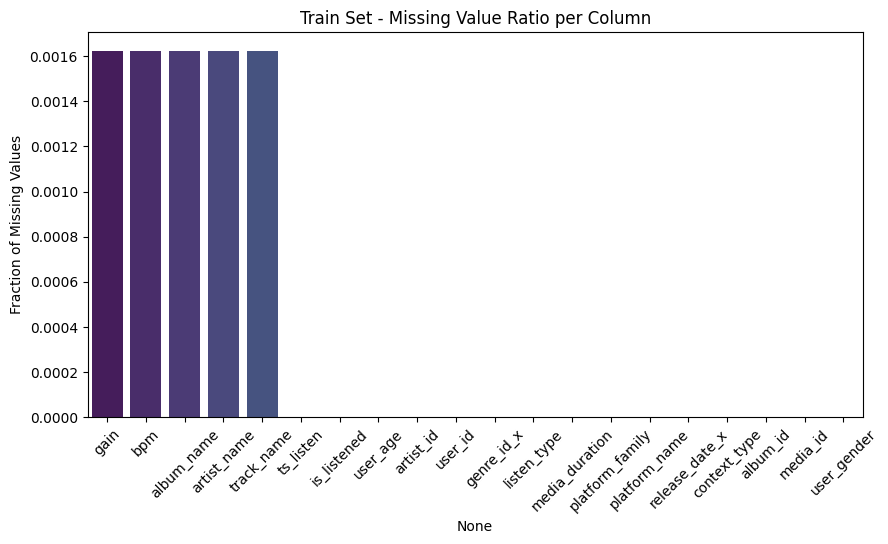


Top genres:
 genre_id_x
0       3666789
7        929538
10       288272
25       269032
27       187946
14       177117
734      141076
297      137968
77       101100
2744      84702
Name: count, dtype: int64


C:\Users\irmak\AppData\Local\Temp\ipykernel_26148\891472433.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index[:20], y=genre_counts.values[:20], palette="coolwarm")


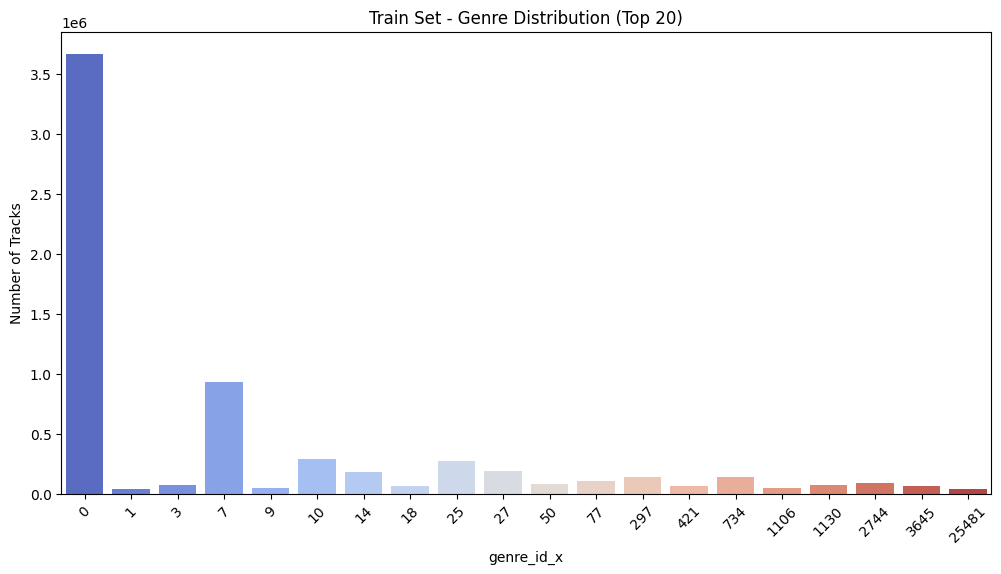


Imbalance ratio (max/min): 3666789.0
2922


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def explore_metadata(df, title="Metadata Overview"):
    # 1. Missing value ratio per column
    missing_ratio = df.isna().mean().sort_values(ascending=False)  # fraction of missing values
    print("Missing value ratio per column:\n", missing_ratio)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=missing_ratio.index, y=missing_ratio.values, palette="viridis")
    plt.xticks(rotation=45)
    plt.ylabel("Fraction of Missing Values")
    plt.title(f"{title} - Missing Value Ratio per Column")
    plt.show()

    # 2. Genre distribution
    if "genre_id_x" in df.columns:
        genre_counts = df['genre_id_x'].value_counts()
        print("\nTop genres:\n", genre_counts.head(10))

        plt.figure(figsize=(12, 6))
        sns.barplot(x=genre_counts.index[:20], y=genre_counts.values[:20], palette="coolwarm")
        plt.xticks(rotation=45)
        plt.ylabel("Number of Tracks")
        plt.title(f"{title} - Genre Distribution (Top 20)")
        plt.show()

        # 3. Imbalance ratio
        imbalance_ratio = genre_counts.max() / genre_counts.min() if genre_counts.min() > 0 else float("inf")
        print(f"\nImbalance ratio (max/min): {imbalance_ratio}")

# Example usage
explore_metadata(deezer_train_df, title="Train Set")
genre_counts = deezer_train_df['genre_id_x'].unique()
print(len(genre_counts))



## Clean Dataset

Same preprocessing procedure as in the script KNN-FM. Here since the data is enriched with metadata, we do a sanity check for BPM and Gain as well.

In [5]:
import pandas as pd

def clean_dataset_full(
    df: pd.DataFrame,
    *,
    company_start: str = "2006-01-01",
    min_duration: int = 5,
    max_duration: int = 3600,
    min_user_age: int = 5,
    max_user_age: int = 100,
    fill_missing_metadata: bool = True,
    metadata_sentinel: str = 'unknown',
    fill_missing_numeric: bool = True,
    numeric_sentinel: float = -1.0,
    bpm_range: tuple[float, float] | None = (30.0, 250.0),
    gain_range: tuple[float, float] | None = (-60.0, 20.0)
):
    df = df.copy()

    # Ensure datetime
    if not pd.api.types.is_datetime64_any_dtype(df['ts_listen']):
        df['ts_listen'] = pd.to_datetime(df['ts_listen'], unit='s', errors='coerce')
    df['datetime'] = df['ts_listen']

    # Parse release_date_x if it exists
    if 'release_date_x' in df.columns:
        df['release_date_dt'] = pd.to_datetime(df['release_date_x'], errors='coerce', format='%Y%m%d')
    else:
        df['release_date_dt'] = pd.NaT

    today_utc = pd.Timestamp.utcnow().tz_localize(None)
    start_dt = pd.Timestamp(company_start)

    # Masks
    m_valid_time = df['datetime'].notna()
    m_after_start = df['datetime'] >= start_dt
    m_not_future = df['datetime'] <= today_utc
    m_release_ok = (~df['release_date_dt'].notna()) | (df['datetime'] >= df['release_date_dt'])

    md = pd.to_numeric(df['media_duration'], errors='coerce')
    m_md_ok = (md >= min_duration) & (md <= max_duration)

    ua = pd.to_numeric(df['user_age'], errors='coerce')
    m_age_ok = (ua >= min_user_age) & (ua <= max_user_age)

    # Apply mask
    mask = m_valid_time & m_after_start & m_not_future & m_release_ok & m_md_ok & m_age_ok
    dropped = len(df) - mask.sum()
    print(f"[clean_full] Dropping {dropped:,} rows by rules: start>={company_start}, not future, "
          f"after release, duration in [{min_duration},{max_duration}], "
          f"age in [{min_user_age},{max_user_age}]")
    df = df.loc[mask]

    # Fill missing metadata
    if fill_missing_metadata:
        for col in ['track_name', 'artist_name', 'album_name']:
            if col in df.columns:
                df[col] = df[col].fillna(metadata_sentinel)

    # Fill missing numeric values
    if fill_missing_numeric:
        for col, valid_range in [('bpm', bpm_range), ('gain', gain_range)]:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(numeric_sentinel)
                if valid_range is not None:
                    min_val, max_val = valid_range
                    df.loc[(df[col] < min_val) | (df[col] > max_val), col] = numeric_sentinel

    # Drop temporary datetime columns
    df = df.drop(columns=['datetime', 'release_date_dt'], errors='ignore')

    return df


In [6]:
deezer_train_clean=clean_dataset_full(deezer_train_df)

[clean_full] Dropping 30,366 rows by rules: start>=2006-01-01, not future, after release, duration in [5,3600], age in [5,100]


In [7]:
deezer_test_clean=clean_dataset_full(deezer_test_df)

[clean_full] Dropping 33 rows by rules: start>=2006-01-01, not future, after release, duration in [5,3600], age in [5,100]


# IMPLICIT MODELING 

Since we have a implicit feedback is_listened in our dataset, it is better to use models that are suitable with these type of rating. For this, here we use Implicit package which comes with many models. Our focus is BPR model, it is a well-known model for it's performance in recommender systems with implicit feedback.

In [ ]:
most_listened = (
    deezer_train_clean
    .groupby(['track_name', 'artist_name'], dropna=False)
    .size()  # counts number of rows per song
    .reset_index(name='listen_count')
    .sort_values('listen_count', ascending=False)
)

# Top 10 most listened songs
top_10 = most_listened.head(10)
print(top_10)


             track_name artist_name  listen_count
334754         Tchikita         Jul         20147
74353               DKR       Booba         17652
239054             Naha         PNL         16284
36622              Bené         PNL         15130
256271          Onizuka         PNL         14341
320982          Starboy  The Weeknd         13641
201334  Let Me Love You    DJ Snake         13075
2870          24K Magic  Bruno Mars         12946
342415     The Greatest         Sia         12850
398060          unknown     unknown         12278


These are the most listened songs.

Create an item lookup table for future operations:

In [ ]:
# Keep only unique item (media_id) and description (track_name) pairs
item_lookup = deezer_train_clean[['media_id', 'track_name']].drop_duplicates()

# Ensure the item IDs are strings for easy lookup
item_lookup['media_id'] = item_lookup['media_id'].astype(str)
item_lookup = item_lookup.reset_index(drop=True)

# Preview
print(item_lookup.head())


  media_id          track_name
0   222606       Seul au monde
1   250467       You're not ok
2   305197              Samuel
3   900502     Mujer Amiga Mia
4   542335  Mr. Tambourine Man


Now we fit an implicit model-
Here is the evaluation helper function that is implemented in the package.

In [10]:
import implicit
from implicit.evaluation import (
    train_test_split,
    precision_at_k,
    ndcg_at_k,
    mean_average_precision_at_k,
    AUC_at_k,
)

def evaluate_model(model, train_mat, val_mat, k=10):
    """Compute ranking metrics (precision / NDCG / MAP / AUC)."""
    return pd.Series({
        f"precision@{k}": precision_at_k(model, train_mat, val_mat, k),
        f"ndcg@{k}"     : ndcg_at_k(model,      train_mat, val_mat, k),
        f"map@{k}"      : mean_average_precision_at_k(model, train_mat, val_mat, k),
        f"auc@{k}"      : AUC_at_k(model,       train_mat, val_mat, k),
    })

#metrics = evaluate_model(model, train_user_item, test_user_item, k=10)


c:\Users\irmak\Desktop\workspace\python-face-recog-tut\facerecog\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This code is focused on building a collaborative filtering recommender system using Bayesian Personalized Ranking (BPR), which is a popular method in implicit feedback systems (i.e., where feedback such as clicks, views, or purchases is used instead of explicit ratings). Our explicit rating is is_listened, weighted depending on track length and release date.


Instead of directly calculating item-to-item similarities, BPR learns implicit patterns from users' interactions with items and builds a latent space that captures item relationships. It doesn't require pre-computing item similarities like traditional CF. It learns the item preferences in the process of training, making it more flexible and powerful, especially with implicit feedback data (like clicks, views, or purchases). Grid Search is used to tune hyperparameters for the BPR model:

**factors**: Number of latent factors (hidden features) to learn.

**regularization:** A parameter to prevent overfitting by penalizing large factor values.

**iterations:** The number of iterations the model will train for.

These values are selected from a range of options, and the best configuration will be chosen based on model performance. The train_test_split function from implicit.evaluation is used to randomly divide the ratings matrix (ratings) into these two sets.

**Training Set:** Used to train the model.

**Test Set:** Used to evaluate the model's performance as validation set.

The BPR model is trained on the training matrix and evaluated on the test matrix (validation split) using precision at K (precision@k), which tells us how well the top-K recommended items match with the user's preferences. After identifying the best hyperparameters, a final model is trained on the entire training matrix (train_matrix).The recommend_for_user_bpr function provides recommendations for a given user by using the trained BPR model.The BPR model learns personalized rankings for each user. For a given user, it predicts the most relevant items based on their past behavior and the model's learned factors.

Retrieve and Rank:

**Retrieval:** The model retrieves items that are most likely to be relevant to the user based on their past interactions.

**Ranking:** The retrieved items are ranked based on their similarity scores. These scores represent the model's prediction of how much a user will like an item.


**Latent Factor Model:** BPR is a matrix factorization technique, which means it tries to learn latent factors for both users and items.

**Pairwise Comparison:** For each user, the model compares two items:

**A positive item:** An item that the user has interacted with (e.g., watched, clicked, or purchased).

**A negative item:** An item that the user has not interacted with.

BPR tries to learn a latent space where the positive item for a user should be ranked higher than the negative item. This ranking process helps to predict the probability that a user will interact with an item based on past behavior, even though they may not have interacted with it yet.BPR can be considered item-based because the model learns to rank items for each user, based on interactions (or implicit feedback) between users and items.



In [ ]:
import pandas as pd
import numpy as np
import random
from scipy.sparse import coo_matrix, csr_matrix
import implicit
from implicit.bpr import BayesianPersonalizedRanking


# --------------------------
# 2️⃣ TLRS / BS-style weighting-> Just to use at some point if wanted
# --------------------------
deezer_train_clean['base_weight'] = deezer_train_clean['is_listened'].astype(float)

deezer_train_clean['weight'] = (
    deezer_train_clean['base_weight'] *
    (1 + 0.5 * deezer_train_clean['listen_type']) *                   # boost if actively listened
    (1 + 0.2 * (deezer_train_clean['media_duration'] / 200)) *       # longer tracks higher weight
    (1 - 0.1 * ((2025 - (deezer_train_clean['release_date_x'] // 10000)) / 50))  # older tracks slightly less
)
deezer_train_clean['weight'] = deezer_train_clean['weight'].clip(lower=0.1)

# --------------------------
# 3️⃣ Map users and items to indices
# --------------------------
user_map = {u: i for i, u in enumerate(deezer_train_clean['user_id'].unique())}
item_map = {i: j for j, i in enumerate(deezer_train_clean['media_id'].unique())}

deezer_train_clean['user_idx'] = deezer_train_clean['user_id'].map(user_map)
deezer_train_clean['item_idx'] = deezer_train_clean['media_id'].map(item_map)

# --------------------------
# 4️⃣ Build sparse matrix
# --------------------------
ratings = coo_matrix(
    (deezer_train_clean['base_weight'], (deezer_train_clean['user_idx'], deezer_train_clean['item_idx'])),
    shape=(len(user_map), len(item_map))
).tocsr()

# --------------------------
# 5️⃣ Sparsity calculation
# --------------------------
matrix_size = ratings.shape[0] * ratings.shape[1]
num_purchases = len(ratings.nonzero()[0])
sparsity = 100 * (1 - (num_purchases / matrix_size))
print(f"Sparsity: {sparsity:.4f}%")

# --------------------------
# 6️⃣ Train/test split function
# --------------------------
def make_train(ratings, pct_test=0.2):
    test_set = ratings.copy()
    test_set[test_set != 0] = 1
    training_set = ratings.copy()
    nonzero_inds = training_set.nonzero()
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1]))
    random.seed(0)
    num_samples = int(np.ceil(pct_test * len(nonzero_pairs)))
    samples = random.sample(nonzero_pairs, num_samples)
    user_inds = [i for i, _ in samples]
    item_inds = [j for _, j in samples]
    training_set[user_inds, item_inds] = 0
    training_set.eliminate_zeros()
    return training_set, test_set, list(set(user_inds))

train_matrix, test_matrix, altered_users = make_train(ratings, pct_test=0.2)

# --------------------------
# 7️⃣ Train the BPR model
# --------------------------

# Initialize the BPR model
model_bpr = BayesianPersonalizedRanking(factors=50, regularization=0.01, iterations=50, random_state=42)

# Fit the model using the training matrix
model_bpr.fit(train_matrix)

# --------------------------
# 8️⃣ Function to recommend for a user (with BPR)
# --------------------------

def recommend_for_user_bpr(query_user_id, model, train_user_item, top_n=10, deezer_train_clean=None):
    """
    Return recommendations for a user using the BPR model.
    If the user is new, recommend popular items.

    Parameters:
    -----------
    query_user_id : int
        ID of the user you want recommendations for.
    model : implicit.bpr.BayesianPersonalizedRanking
        Trained BPR model.
    train_user_item : csr_matrix
        Sparse matrix of user-item interactions.
    top_n : int
        Number of recommendations to return.
    deezer_train_clean : pd.DataFrame
        DataFrame containing item metadata like 'media_id' and 'track_name'.

    Returns:
    --------
    pd.DataFrame
        DataFrame of recommended items with similarity scores.
    """
    # Check if the user exists in the model's internal user space (user_idx)
    if query_user_id not in user_map:
        print(f"User {query_user_id} not found. Recommending popular items instead.")
        return recommend_popular_items(train_user_item, top_n, deezer_train_clean)

    # Get the internal index for the query user
    user_idx = user_map[query_user_id]

    # Get recommendations from the BPR model for the user
    recommended_items, scores = model.recommend(user_idx, train_user_item, N=top_n, filter_already_liked_items=False)

    recs = []
    for item_code, score in zip(recommended_items, scores):
        # Map internal code to item_id using item_map
        item_id = list(item_map.keys())[list(item_map.values()).index(item_code)]  # Map internal code to item_id

        # Fetch track name from deezer_train_clean based on item_id
        track_name = deezer_train_clean.loc[deezer_train_clean['media_id'] == item_id, 'track_name'].values[0]

        recs.append({
            "item_id": item_id,
            "track_name": track_name,
            "similarity": round(float(score), 4)
        })

    return pd.DataFrame(recs)

# --------------------------
# 9️⃣ Popular item recommendation function
# --------------------------

def recommend_popular_items(train_user_item, top_n=10, deezer_train_clean=None):
    """Recommend the most popular items (items with the most interactions)."""

    # Get the number of interactions (non-zero entries) for each item (sum along the rows of the sparse matrix)
    item_counts = train_user_item.getnnz(axis=0)  # Number of non-zero entries per item (most interactions)

    # Get the top N popular items
    top_items = np.argsort(item_counts)[::-1][:top_n]  # Sort and get top N items

    # Map item indices to item IDs
    recommendations = []
    for item_code in top_items:
        # Map internal code to item_id using item_map
        item_id = list(item_map.keys())[list(item_map.values()).index(item_code)]  # Map internal code to item_id

        # Fetch track name from deezer_train_clean based on item_id
        track_name = deezer_train_clean.loc[deezer_train_clean['media_id'] == item_id, 'track_name'].values[0]
        recommendations.append({
            "item_id": item_id,
            "track_name": track_name,
            "popularity": item_counts[item_code]
        })

    return pd.DataFrame(recommendations)



Sparsity: 99.9696%


100%|██████████| 50/50 [00:27<00:00,  1.82it/s, train_auc=89.21%, skipped=3.11%]


In [17]:
    eval_results = evaluate_model(model_bpr, train_matrix, test_matrix, k=10)
    print(f"Evaluation Results: {eval_results}")

100%|██████████| 19911/19911 [00:32<00:00, 616.69it/s]

Evaluation Results: precision@10    0.177617
ndcg@10         0.183868
map@10          0.106216
auc@10          0.508882
dtype: float64


Here we tested the model with is_listened and no weights. Precision at 10 is 1.77 which is not very high. We will try to improve it with weights and other models. Below we do a grid search with weighted ratings.

High Sparsity (99%) indicates that there are many possible interactions (user-item pairs) that are missing. This leads to sparse matrices where most of the entries are zero or absent. To mitigate this, a hybrid approach would work the best-

In [ ]:
import pandas as pd
import numpy as np
import random
from scipy.sparse import coo_matrix, csr_matrix
from implicit.bpr import BayesianPersonalizedRanking
from implicit.evaluation import (
    train_test_split,
    precision_at_k,
    ndcg_at_k,
    mean_average_precision_at_k,
    AUC_at_k,
)
from sklearn.model_selection import ParameterGrid

# --------------------------
# 1️⃣ Grid Search Setup
# --------------------------

# Define the hyperparameter grid to search over
param_grid = {
    'factors': [10, 20, 50],  # Number of latent factors
    'regularization': [0.01, 0.1, 0.2],  # Regularization strength
    'iterations': [10, 20, 50]  # Number of iterations
}

# --------------------------
# 2️⃣ Train/Test Split
# --------------------------

def make_train(ratings, pct_test=0.2):
    """Create training and test sets by splitting the ratings matrix."""
    train, test = train_test_split(ratings, train_percentage=1-pct_test)
    return train, test

# --------------------------
# 3️⃣ Hyperparameter Tuning with Grid Search
# --------------------------

# Perform grid search over the hyperparameter space
best_score = -np.inf
best_params = None

# Define the sparse matrix with correct shape using user_map and item_map
ratings = csr_matrix(
    (deezer_train_clean['weight'],
     (deezer_train_clean['user_idx'], deezer_train_clean['item_idx'])),
    shape=(len(user_map), len(item_map))
)

train_matrix, test_matrix = make_train(ratings, pct_test=0.2)

for params in ParameterGrid(param_grid):
    print(f"Training BPR with params: {params}")

    # Initialize the BPR model with the current hyperparameters
    model_bpr = BayesianPersonalizedRanking(
        factors=params['factors'],
        regularization=params['regularization'],
        iterations=params['iterations'],
        random_state=42
    )

    model_bpr.fit(train_matrix)

    eval_results = evaluate_model(model_bpr, train_matrix, test_matrix, k=10)
    print(f"Evaluation Results: {eval_results}")

    if eval_results["precision@10"] > best_score:
        best_score = eval_results["precision@10"]
        best_params = params

# --------------------------
# 4️⃣ Output the best hyperparameters
# --------------------------

print(f"Best Hyperparameters: {best_params}")
print(f"Best Precision at 10: {best_score:.4f}")

# --------------------------
# 5️⃣ Train final model with best hyperparameters
# --------------------------

# Train the final model with the best hyperparameters
best_model_bpr = BayesianPersonalizedRanking(
    factors=best_params['factors'],
    regularization=best_params['regularization'],
    iterations=best_params['iterations'],
    random_state=42
)

best_model_bpr.fit(train_matrix)

# --------------------------
# 6️⃣ Get Recommendations with the Best Model
# --------------------------

def recommend_for_user_bpr(query_user_id, model, train_user_item, top_n=10, deezer_train_clean=None):
    """Get recommendations for a user using the BPR model."""

    # Check if the user exists
    if query_user_id not in user_map:
        print(f"User {query_user_id} not found. Recommending popular items instead.")
        return recommend_popular_items(train_user_item, top_n, deezer_train_clean)

    user_idx = user_map[query_user_id]

    recommended_items, scores = model.recommend(user_idx, train_user_item, N=top_n, filter_already_liked_items=False)

    recs = []
    for item_code, score in zip(recommended_items, scores):
        item_id = list(item_map.keys())[list(item_map.values()).index(item_code)]
        track_name = deezer_train_clean.loc[deezer_train_clean['media_id'] == item_id, 'track_name'].values[0]

        recs.append({
            "item_id": item_id,
            "track_name": track_name,
            "similarity": round(float(score), 4)
        })

    return pd.DataFrame(recs)




Training BPR with params: {'factors': 10, 'iterations': 10, 'regularization': 0.01}


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.139081
ndcg@10         0.135807
map@10          0.075775
auc@10          0.521139
dtype: float64
Training BPR with params: {'factors': 10, 'iterations': 10, 'regularization': 0.1}


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.049475
ndcg@10         0.050418
map@10          0.020940
auc@10          0.506423
dtype: float64
Training BPR with params: {'factors': 10, 'iterations': 10, 'regularization': 0.2}


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.028473
ndcg@10         0.026515
map@10          0.009460
auc@10          0.503160
dtype: float64
Training BPR with params: {'factors': 10, 'iterations': 20, 'regularization': 0.01}


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.136733
ndcg@10         0.135365
map@10          0.072909
auc@10          0.524332
dtype: float64
Training BPR with params: {'factors': 10, 'iterations': 20, 'regularization': 0.1}


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.061649
ndcg@10         0.060009
map@10          0.024581
auc@10          0.509726
dtype: float64
Training BPR with params: {'factors': 10, 'iterations': 20, 'regularization': 0.2}


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.039097
ndcg@10         0.041192
map@10          0.016662
auc@10          0.504892
dtype: float64
Training BPR with params: {'factors': 10, 'iterations': 50, 'regularization': 0.01}


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.104999
ndcg@10         0.106019
map@10          0.055107
auc@10          0.523621
dtype: float64
Training BPR with params: {'factors': 10, 'iterations': 50, 'regularization': 0.1}


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.075420
ndcg@10         0.076582
map@10          0.036380
auc@10          0.512712
dtype: float64
Training BPR with params: {'factors': 10, 'iterations': 50, 'regularization': 0.2}


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.030918
ndcg@10         0.033940
map@10          0.013356
auc@10          0.503877
dtype: float64
Training BPR with params: {'factors': 20, 'iterations': 10, 'regularization': 0.01}


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.135898
ndcg@10         0.132397
map@10          0.073156
auc@10          0.520652
dtype: float64
Training BPR with params: {'factors': 20, 'iterations': 10, 'regularization': 0.1}


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.044365
ndcg@10         0.038465
map@10          0.014223
auc@10          0.504764
dtype: float64
Training BPR with params: {'factors': 20, 'iterations': 10, 'regularization': 0.2}


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.040761
ndcg@10         0.037450
map@10          0.013965
auc@10          0.505685
dtype: float64
Training BPR with params: {'factors': 20, 'iterations': 20, 'regularization': 0.01}


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.141814
ndcg@10         0.139490
map@10          0.076549
auc@10          0.524255
dtype: float64
Training BPR with params: {'factors': 20, 'iterations': 20, 'regularization': 0.1}


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.062988
ndcg@10         0.061834
map@10          0.025940
auc@10          0.510424
dtype: float64
Training BPR with params: {'factors': 20, 'iterations': 20, 'regularization': 0.2}


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.030641
ndcg@10         0.033662
map@10          0.013550
auc@10          0.503897
dtype: float64
Training BPR with params: {'factors': 20, 'iterations': 50, 'regularization': 0.01}


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.130517
ndcg@10         0.133673
map@10          0.072941
auc@10          0.528302
dtype: float64
Training BPR with params: {'factors': 20, 'iterations': 50, 'regularization': 0.1}


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.076609
ndcg@10         0.079732
map@10          0.038292
auc@10          0.513484
dtype: float64
Training BPR with params: {'factors': 20, 'iterations': 50, 'regularization': 0.2}


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.044845
ndcg@10         0.046196
map@10          0.018573
auc@10          0.506053
dtype: float64
Training BPR with params: {'factors': 50, 'iterations': 10, 'regularization': 0.01}


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.133580
ndcg@10         0.130251
map@10          0.071386
auc@10          0.519969
dtype: float64
Training BPR with params: {'factors': 50, 'iterations': 10, 'regularization': 0.1}


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.046857
ndcg@10         0.045291
map@10          0.018211
auc@10          0.505569
dtype: float64
Training BPR with params: {'factors': 50, 'iterations': 10, 'regularization': 0.2}


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.033740
ndcg@10         0.037105
map@10          0.015034
auc@10          0.504333
dtype: float64
Training BPR with params: {'factors': 50, 'iterations': 20, 'regularization': 0.01}


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.141568
ndcg@10         0.139199
map@10          0.076622
auc@10          0.524060
dtype: float64
Training BPR with params: {'factors': 50, 'iterations': 20, 'regularization': 0.1}


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.059019
ndcg@10         0.057328
map@10          0.023466
auc@10          0.510039
dtype: float64
Training BPR with params: {'factors': 50, 'iterations': 20, 'regularization': 0.2}


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.038659
ndcg@10         0.042834
map@10          0.017713
auc@10          0.507047
dtype: float64
Training BPR with params: {'factors': 50, 'iterations': 50, 'regularization': 0.01}


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.144883
ndcg@10         0.147752
map@10          0.082390
auc@10          0.530825
dtype: float64
Training BPR with params: {'factors': 50, 'iterations': 50, 'regularization': 0.1}


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.075901
ndcg@10         0.076554
map@10          0.036459
auc@10          0.512900
dtype: float64
Training BPR with params: {'factors': 50, 'iterations': 50, 'regularization': 0.2}


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

  0%|          | 0/19259 [00:00<?, ?it/s]

Evaluation Results: precision@10    0.042040
ndcg@10         0.043992
map@10          0.017627
auc@10          0.506273
dtype: float64
Best Hyperparameters: {'factors': 50, 'iterations': 50, 'regularization': 0.01}
Best Precision at 10: 0.1449


  0%|          | 0/50 [00:00<?, ?it/s]

     item_id             track_name  similarity
0    2603200  Lucky (Album Version)      3.3541
1  133103632                  Weary      3.2700
2    5645240            Window Seat      3.2648
3    2171224                At Last      3.2407
4  127677897              Soul Eyes      3.1940


We see that best model parameters are factors at 50, iterations at 50 and regularization at 0.01. The best precision @ 10 achieved is 0.1449. This is quite low however, for the size of the data it is understandable- almost 2 of the top 10 items are relevant for all users.

However, with the same hyperparameters, the model with no weights performed better at precision @10 with 1.77. 

Example Recommendation for User :

In [ ]:

# Get recommendations for user 922
recommendations = recommend_for_user_bpr(
    query_user_id=922,
    model=model_bpr,
    train_user_item=train_matrix,
    top_n=5,
    deezer_train_clean=deezer_train_clean
)

print(recommendations)


     item_id                   track_name  similarity
0  128477965         Building a Beginning      3.5095
1  133583958                     Carry On      3.4456
2    2603200        Lucky (Album Version)      3.4391
3  128958452  There's a Break in the Road      3.2882
4   10274015         You Made Me Love You      3.2561
